## Experiments

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torchvision

import pickle
import time

import sys
sys.path.append('..')
from core import samplers, utility, datasets
from core.distributions import IsingMNIST
from core.dHMC import DHMCSampler, get_f_mnist, get_f_update_mnist

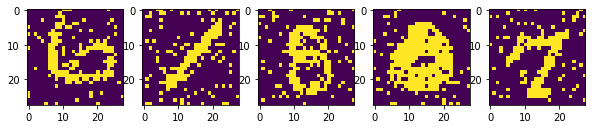

In [3]:
mnist_dataset = datasets.BinMNIST('../data/binMNIST', train=True, 
                                  transform=torchvision.transforms.ToTensor(), download=True)
batch_size = 20
img_batch = np.zeros([batch_size,28,28])
for i in range(batch_size):
    img, label = mnist_dataset[i]
    img_batch[i] = img.squeeze(0).numpy()
    
noise = np.random.uniform(size=img_batch.shape) > 0.9
noisy_batch = (img_batch+noise) % 2

figsize(10,4)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(noisy_batch[i])
plt.show()

In [4]:
n_samples = 10
batch_size = 15

target = IsingMNIST(noisy_batch[0], beta=1.0, eta=2.1)
initial_states = noisy_batch

primes = utility.generate_primes(100000)
gibbs_d = samplers.DGibbs(target, v_coeffs=np.sqrt(primes)[:img_batch.shape[1]*img_batch.shape[2]])
suzuki = samplers.DGibbs(target)
gibbs = samplers.Gibbs(target)

In [23]:
def plot_samples(sampler, state0, xlabel):
    sampler.initialize(state0.flatten())    
    samples = np.zeros([n_samples,img_batch.shape[1]*img_batch.shape[2]])
    for x_id in range(n_samples):
        samples[x_id], _ = sampler.iterate_n(50)
        
    fig, ax = plt.subplots(1, n_samples+1, figsize=(18, 6))
    ax[0].imshow(state0.reshape([img_batch.shape[1],img_batch.shape[2]]), 
                 cmap='gray', interpolation='nearest')
    ax[0].set_title('init')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].set_ylabel(xlabel, fontsize=20)
    for x_id in range(n_samples):
        ax[x_id+1].set_title('iter %d' % ((x_id+1)*50))
        ax[x_id+1].imshow(samples[x_id].reshape([img_batch.shape[1],img_batch.shape[2]]), 
                          cmap='gray', interpolation='nearest')
        ax[x_id+1].set_axis_off()
        
def plot_dHMC(state0):
    dhmc = DHMCSampler(get_f_mnist(noisy_batch[0].astype(float)), 
                       get_f_update_mnist(noisy_batch[0].astype(float)), 784, 784)
    dt = 0.9 * np.array([.8, 1])
    nstep = [1, 2]
    theta0 = initial_states[0].flatten().astype(np.float)
    prev_sample = state0
    samples = np.zeros([n_samples,img_batch.shape[1]*img_batch.shape[2]])
    for x_id in range(n_samples):
        x, logp_samples, time_elapsed = dhmc.run_sampler(prev_sample.flatten(), dt, nstep, 
                                                         n_burnin=0, n_sample=50, 
                                                         seed=1, n_update=1)
        samples[x_id] = x[-1]
        prev_sample = x[-1]
    samples = np.floor(samples)
        
    fig, ax = plt.subplots(1, n_samples+1, figsize=(18, 6))
    ax[0].imshow(state0.reshape([img_batch.shape[1],img_batch.shape[2]]), 
                 cmap='gray', interpolation='nearest')
    ax[0].set_title('init')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].set_ylabel('dHMC', fontsize=20)
    for x_id in range(n_samples):
        ax[x_id+1].set_title('iter %d' % ((x_id+1)*50))
        ax[x_id+1].imshow(samples[x_id].reshape([img_batch.shape[1],img_batch.shape[2]]), 
                          cmap='gray', interpolation='nearest')
        ax[x_id+1].set_axis_off()

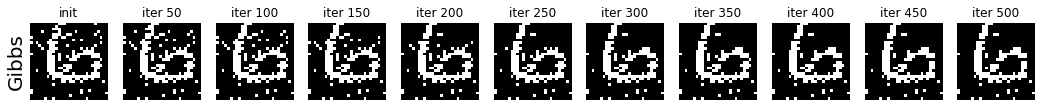

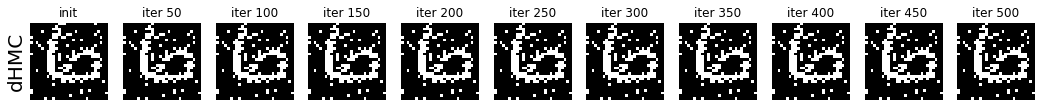

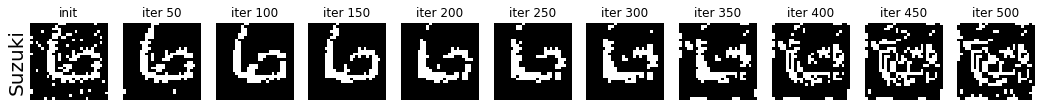

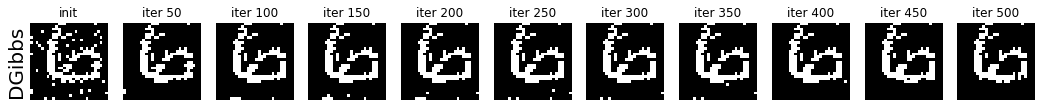

In [24]:
plot_samples(gibbs, initial_states[0], 'Gibbs')
plt.savefig('../results/mnist/gibbs_denoise.pdf',bbox_inches='tight')
plot_dHMC(initial_states[0])
plt.savefig('../results/mnist/dHMC_denoise.pdf',bbox_inches='tight')
plot_samples(suzuki, initial_states[0], 'Suzuki')
plt.savefig('../results/mnist/suzuki_denoise.pdf',bbox_inches='tight')
plot_samples(gibbs_d, initial_states[0], 'DGibbs')
plt.savefig('../results/mnist/d_denoise.pdf',bbox_inches='tight')

In [ ]:
samples_gibbs = np.zeros([n_samples,img_batch.shape[1],img_batch.shape[2]])
for i in range(len(samples_gibbs)):
gibbs.iterate_n(img_batch.shape[1]*img_batch.shape[2])

In [5]:
pure_noise = (torch.rand(img_batch.shape) > 0.5).to(device)
ising_gibbs = distributions.IsingModel2DBatch(noisy_batch.clone(), noisy_batch.clone(), beta=1.0, eta=2.1)
ising_suzuki = distributions.IsingModel2DBatch(noisy_batch.clone(), noisy_batch.clone(), beta=1.0, eta=2.1)
ising_gibbs_d = distributions.IsingModel2DBatch(noisy_batch.clone(), noisy_batch.clone(), beta=1.0, eta=2.1)

In [6]:
gibbs = samplers.GibbsBatch(ising_gibbs)
suzuki = samplers.DGibbsBatch(ising_suzuki)

primes = utility.generate_primes(100000)
print('prime numbers generated:', len(primes))
coeffs = torch.from_numpy(np.power(primes, np.ones_like(primes)/2.)[:784])
gibbs_d = samplers.DGibbsBatch(ising_gibbs_d, v_coeffs=coeffs)

prime numbers generated: 9842


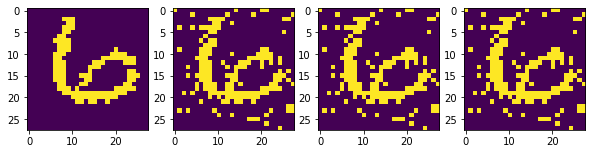

In [7]:
figsize(10,5)
plt.subplot(141)
plt.imshow(img_batch.cpu().numpy()[0])
plt.subplot(142)
plt.imshow(gibbs.dist.spins.cpu().numpy()[0])
plt.subplot(143)
plt.imshow(gibbs_d.dist.spins.cpu().numpy()[0])
plt.subplot(144)
plt.imshow(suzuki.dist.spins.cpu().numpy()[0])
plt.show()

In [8]:
%%time
n_iter = 1000*100
for i in range(n_iter):
    gibbs.iterate()

CPU times: user 31.1 s, sys: 6.43 ms, total: 31.1 s
Wall time: 31.1 s


In [9]:
%%time
n_iter = 1000*100
for i in range(n_iter):
    gibbs_d.iterate()

CPU times: user 52.9 s, sys: 12.9 ms, total: 52.9 s
Wall time: 52.9 s


In [8]:
n_iter = 10000
probs = np.zeros([batch_size,n_iter])
probs_d = np.zeros([batch_size,n_iter])
probs_s = np.zeros([batch_size,n_iter])
for i in range(n_iter):
    probs[:,i] = gibbs.dist.get_log_prob().cpu().numpy()
    gibbs.iterate()
    probs_d[:,i] = gibbs_d.dist.get_log_prob().cpu().numpy()
    gibbs_d.iterate()
    probs_s[:,i] = suzuki.dist.get_log_prob().cpu().numpy()
    suzuki.iterate()

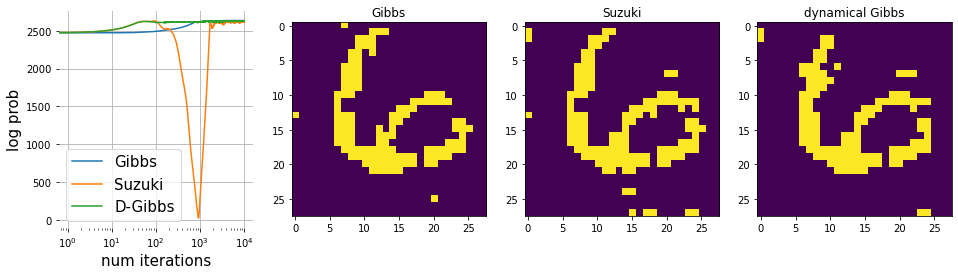

In [9]:
figsize(16,4)
plt.subplot(141)
plt.plot(np.mean(probs, axis=0), label='Gibbs')
plt.plot(np.mean(probs_s, axis=0), label='Suzuki')
plt.plot(np.mean(probs_d, axis=0), label='D-Gibbs')
plt.ylabel('log prob', fontsize=15)
plt.xlabel('num iterations', fontsize=15)
plt.xscale('log')
plt.box(False)
plt.legend(fontsize=15)
plt.grid()
plt.subplot(142)
plt.imshow(gibbs.dist.get_state().cpu().numpy()[0])
plt.title('Gibbs')
plt.subplot(143)
plt.imshow(suzuki.dist.get_state().cpu().numpy()[0])
plt.title('Suzuki')
plt.subplot(144)
plt.imshow(gibbs_d.dist.get_state().cpu().numpy()[0])
plt.title('dynamical Gibbs')
plt.show()

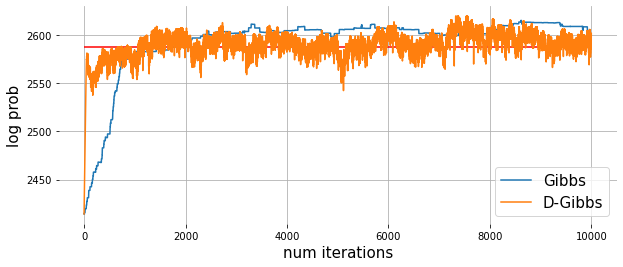

In [10]:
im_id = 17

figsize(10,4)
plt.plot(probs[im_id], label='Gibbs')
plt.plot(probs_d[im_id], label='D-Gibbs')
plt.hlines(ising_gt.get_log_prob()[im_id].cpu().numpy(), 0, probs.shape[1], colors='red')
plt.ylabel('log prob', fontsize=15)
plt.xlabel('num iterations', fontsize=15)
# plt.xscale('log')
plt.box(False)
plt.legend(fontsize=15)
plt.grid()

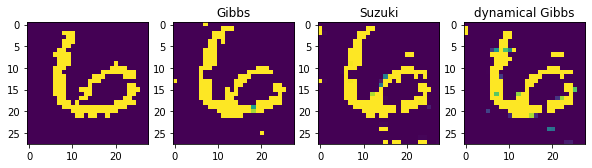

In [11]:
def get_mean_sample(sampler, n_last):
    samples = torch.stack(sampler.samples[-n_last:]).cpu().numpy()
    weights = torch.stack(sampler.weights[-n_last:]).cpu().numpy()[:,:,np.newaxis]
    weights /= np.sum(weights, axis=0, keepdims=True)
    mean_sample = np.sum(samples*weights, axis=0).reshape([-1,28,28])
    return mean_sample

n_last = 100
mean_sample_gibbs = get_mean_sample(gibbs, n_last)
mean_sample_d = get_mean_sample(gibbs_d, n_last)
mean_sample_s = get_mean_sample(suzuki, n_last)

plt.subplot(141)
plt.imshow(img_batch.cpu().numpy()[0])
plt.subplot(142)
plt.imshow(mean_sample_gibbs[0])
plt.title('Gibbs')
plt.subplot(143)
plt.imshow(mean_sample_s[0])
plt.title('Suzuki')
plt.subplot(144)
plt.imshow(mean_sample_d[0])
plt.title('dynamical Gibbs')
plt.show()

In [39]:
samples = torch.stack(gibbs.samples[-1000:]).cpu().numpy()
weights = torch.stack(gibbs.weights[-1000:]).cpu().numpy()
ess, batch_variance = batch_means_ess(samples,weights)
samples = torch.stack(gibbs_d.samples[-1000:]).cpu().numpy()
weights = torch.stack(gibbs_d.weights[-1000:]).cpu().numpy()
ess_d, batch_variance_d = batch_means_ess(samples,weights)
samples = torch.stack(suzuki.samples[-1000:]).cpu().numpy()
weights = torch.stack(suzuki.weights[-1000:]).cpu().numpy()
ess_s, _ = batch_means_ess(samples,weights)

In [57]:
np.sum(batch_variance[0] < 1e-5)

765

In [ ]:
samples*

In [58]:
np.sum(batch_variance_d[0] < 1e-5)

678

In [30]:
def batch_means_ess(x,w):
    """ Estimate the effective sample size as the ratio of the variance
    of the batch means to the variance of the chain. As explained here:
    https://arxiv.org/pdf/1011.0175.pdf. We expect the chain in the format
    Time-Steps, Num-Chains, Dimension (T, M, D) and the weights in the format
    Time-Steps, Num-Chains, Dimension (T, M)"""
    
    T, M, D = x.shape
    weights = w[:,:,np.newaxis].copy()
    weights = weights/np.sum(weights, axis=0, keepdims=True)
    num_batches = int(np.floor(T ** (1 / 3)))
    batch_size = int(np.floor(num_batches ** 2))
    batch_means = []
    for i in range(num_batches):
        batch = x[batch_size * i:batch_size * i + batch_size]
        batch_weights = weights[batch_size * i:batch_size * i + batch_size].copy()
        batch_weights /= np.sum(batch_weights, axis=0, keepdims=True)
        batch_means.append(np.sum(batch*batch_weights, axis=0))
    batch_variance = np.var(np.array(batch_means), axis=0)
    chain_mean = np.sum(x*weights, axis=0, keepdims=True)
    chain_variance = np.sum(weights*(x-chain_mean)**2, axis=0)
    act = batch_size * batch_variance / (chain_variance+1e-20)
    act[batch_variance < 1e-10] = np.inf
    act[chain_variance < 1e-10] = np.inf
    return 1/act, batch_variance